In [2]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage, elo_save_feature
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys
import glob
from joblib import Parallel, delayed

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']

In [63]:
base = utils.read_pkl_gzip('../input/base_no_out_clf.gz').set_index(key)
df_type = pd.read_csv('../input/card_ids_grouping.csv').set_index(key)
base = base.join(df_type)

#========================================================================
# 予測値を結合する
submit_list = glob.glob('../ensemble/good_submit_ensemble/*')
submit_list = glob.glob('../ensemble/good_submit_ensemble/tmp/*')
for path in submit_list:
    cv = 'CV' + re.search(r'CV([^/.]*)_LB', path.replace('.', '-')).group(1)
    if path.count('gz'):
        tmp = utils.read_pkl_gzip(path)[[key, 'prediction']].set_index(key)
        lb = 'LB' + re.search(r'LB([^/.]*).gz', path.replace('.', '-')).group(1)
    else:
        tmp = pd.read_csv(path)[[key, 'prediction']].set_index(key)
        lb = 'LB' + re.search(r'LB([^/.]*).csv', path.replace('.', '-')).group(1)
    print(lb, cv)
    base[f"{lb}_{cv[:7]}"] = tmp
base.head()
#======================================================================

LB3-6590 CV3-6059
LB3-662 CV3-60558
LB3-663 CV3-6003
LB3-658 CV3-6035


,target,first_active_month,hist_purchase_date_max,hist_purchase_month_max,hist_purchase_date_min,hist_purchase_month_min,new_purchase_date_max,new_purchase_month_max,new_purchase_date_min,new_purchase_month_min,hist_personal_term,new_personal_term,hist_regist_term,new_regist_term,no_out_flg,clf_pred,type,LB3-6590_CV3-605,LB3-662_CV3-605,LB3-663_CV3-600,LB3-658_CV3-603
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,-0.820283,2017-06-01,2018-02-25 09:31:15,2018-03-01,2017-06-27 14:18:08,2017-06-01,2018-04-29 11:23:05,2018-05-01,2018-03-05 14:04:36,2018-03-01,9,2.0,9,11.0,1.0,0.000444,2,-0.319724,-0.345815,-0.306923,-0.319547
C_ID_3d0044924f,0.392913,2017-01-01,2018-01-31 22:31:09,2018-02-01,2017-01-06 16:29:42,2017-01-01,2018-03-30 06:48:26,2018-04-01,2018-02-01 17:07:54,2018-02-01,13,2.0,13,15.0,0.0,0.007831,0,-0.022252,0.288418,-0.021068,0.019753
C_ID_d639edf6cd,0.688056,2016-08-01,2018-02-27 19:08:25,2018-03-01,2017-01-11 08:21:22,2017-01-01,2018-04-28 17:43:11,2018-05-01,2018-04-28 17:43:11,2018-04-01,14,1.0,19,18.0,0.0,0.004074,2,0.773737,0.843978,0.762709,0.773337
C_ID_186d6a6901,0.142495,2017-09-01,2018-02-28 11:44:40,2018-03-01,2017-09-26 16:22:21,2017-09-01,2018-04-18 11:00:11,2018-05-01,2018-03-07 11:55:06,2018-03-01,6,2.0,6,8.0,0.0,0.000797,2,0.203239,0.202080,0.199781,0.203058
C_ID_cdbd2c0db2,-0.159749,2017-11-01,2018-02-28 20:40:41,2018-03-01,2017-11-12 00:00:00,2017-11-01,2018-04-28 18:50:25,2018-05-01,2018-03-02 11:55:43,2018-03-01,4,2.0,4,6.0,1.0,0.000251,10,-0.289072,-0.253839,-0.260867,-0.289072


In [64]:
min_thres = 0.01
# Low Outlier Ratio
type0_flg0_lower = ( (base['type']==0) & (base['no_out_flg']==0) ) & (base['clf_pred']<min_thres)
type0_flg1_lower = ( (base['type']==0) & (base['no_out_flg']==1) ) & (base['clf_pred']<min_thres)
type1_flg0_lower = ( (base['type']==1) & (base['no_out_flg']==0) ) & (base['clf_pred']<min_thres)
type1_flg1_lower = ( (base['type']==1) & (base['no_out_flg']==1) ) & (base['clf_pred']<min_thres)
type2_flg0_lower = ( (base['type']==2) & (base['no_out_flg']==0) ) & (base['clf_pred']<min_thres)
type2_flg1_lower = ( (base['type']==2) & (base['no_out_flg']==1) ) & (base['clf_pred']<min_thres)

# High Outlier Ratio
type0_flg0_higher = ( (base['type']==0) & (base['no_out_flg']==0) ) & (base['clf_pred']>=min_thres)
type0_flg1_higher = ( (base['type']==0) & (base['no_out_flg']==1) ) & (base['clf_pred']>=min_thres)
type1_flg0_higher = ( (base['type']==1) & (base['no_out_flg']==0) ) & (base['clf_pred']>=min_thres)
type1_flg1_higher = ( (base['type']==1) & (base['no_out_flg']==1) ) & (base['clf_pred']>=min_thres)
type2_flg0_higher = ( (base['type']==2) & (base['no_out_flg']==0) ) & (base['clf_pred']>=min_thres)
type2_flg1_higher = ( (base['type']==2) & (base['no_out_flg']==1) ) & (base['clf_pred']>=min_thres)
type10 = (base['type']==10)

base.loc[type0_flg0_lower , 'group'] = 'type0_flg0_lower'
base.loc[type0_flg1_lower , 'group'] = 'type0_flg1_lower'
base.loc[type1_flg0_lower , 'group'] = 'type1_flg0_lower'
base.loc[type1_flg1_lower , 'group'] = 'type1_flg1_lower'
base.loc[type2_flg0_lower , 'group'] = 'type2_flg0_lower'
base.loc[type2_flg1_lower , 'group'] = 'type2_flg1_lower'
base.loc[type0_flg0_higher, 'group'] = 'type0_flg0_higher'
base.loc[type0_flg1_higher, 'group'] = 'type0_flg1_higher'
base.loc[type1_flg0_higher, 'group'] = 'type1_flg0_higher'
base.loc[type1_flg1_higher, 'group'] = 'type1_flg1_higher'
base.loc[type2_flg0_higher, 'group'] = 'type2_flg0_higher'
base.loc[type2_flg1_higher, 'group'] = 'type2_flg1_higher'
base.loc[type10           , 'group'] = 'type10'

# check cv
# y_pred = train['CV3-605_LB3-659']
# y_train = train[target]
# score = np.sqrt(mean_squared_error(y_train, y_pred))
# score

In [65]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
def get_new_columns(name,aggs):
#     return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

group_list = np.sort(base['group'].unique())
lb_list = sorted([col for col in base.columns if col.count('LB')])
train = base[~base[target].isnull()]
train['outlier'] = train[target].map(lambda x: 1 if x<-30 else 0)
display(train.groupby('group')['outlier'].sum())

cv_lb_list = []
score_list = []
fue_list = []
for group in group_list:
    tmp_group = train[train['group']==group]
    cnt_id = np.array(tmp_group.index).shape[0]
    if cnt_id<1000:
        continue
    cnt_out = tmp_group['outlier'].sum()
    print(f"Group: {group} | Count ID: {cnt_id} | Count Outlier: {cnt_out}")
    
    for i, lb in enumerate(lb_list):
        y_train = tmp_group[target].values
        y_pred = tmp_group[lb].values
        score = np.sqrt(mean_squared_error(y_train, y_pred))
        if i==0:
            base_score = score
#             print(f"LB: {lb} | CV: {score}")
        else:
#             print(f"LB: {lb} | CV: {score-base_score}")
            pass
        cv_lb_list.append(lb)
        score_list.append(score-base_score)
        fue_list.append(group)

df_viz = pd.DataFrame([fue_list, cv_lb_list, score_list]).T
df_viz.columns = ['group', 'cv_lb', 'score']

group
type0_flg0_higher    1717
type0_flg0_lower       90
type0_flg1_higher       0
type0_flg1_lower        4
type10                  0
type1_flg0_higher       2
type1_flg0_lower       14
type1_flg1_higher       0
type1_flg1_lower       11
type2_flg0_higher      96
type2_flg0_lower      273
type2_flg1_lower        0
Name: outlier, dtype: int64

Group: type0_flg0_higher | Count ID: 28285 | Count Outlier: 1717
Group: type0_flg0_lower | Count ID: 19040 | Count Outlier: 90
Group: type0_flg1_lower | Count ID: 1546 | Count Outlier: 4
Group: type10 | Count ID: 27766 | Count Outlier: 0
Group: type1_flg0_lower | Count ID: 10161 | Count Outlier: 14
Group: type1_flg1_lower | Count ID: 7430 | Count Outlier: 11
Group: type2_flg0_higher | Count ID: 5540 | Count Outlier: 96
Group: type2_flg0_lower | Count ID: 97628 | Count Outlier: 273
Group: type2_flg1_lower | Count ID: 4431 | Count Outlier: 0


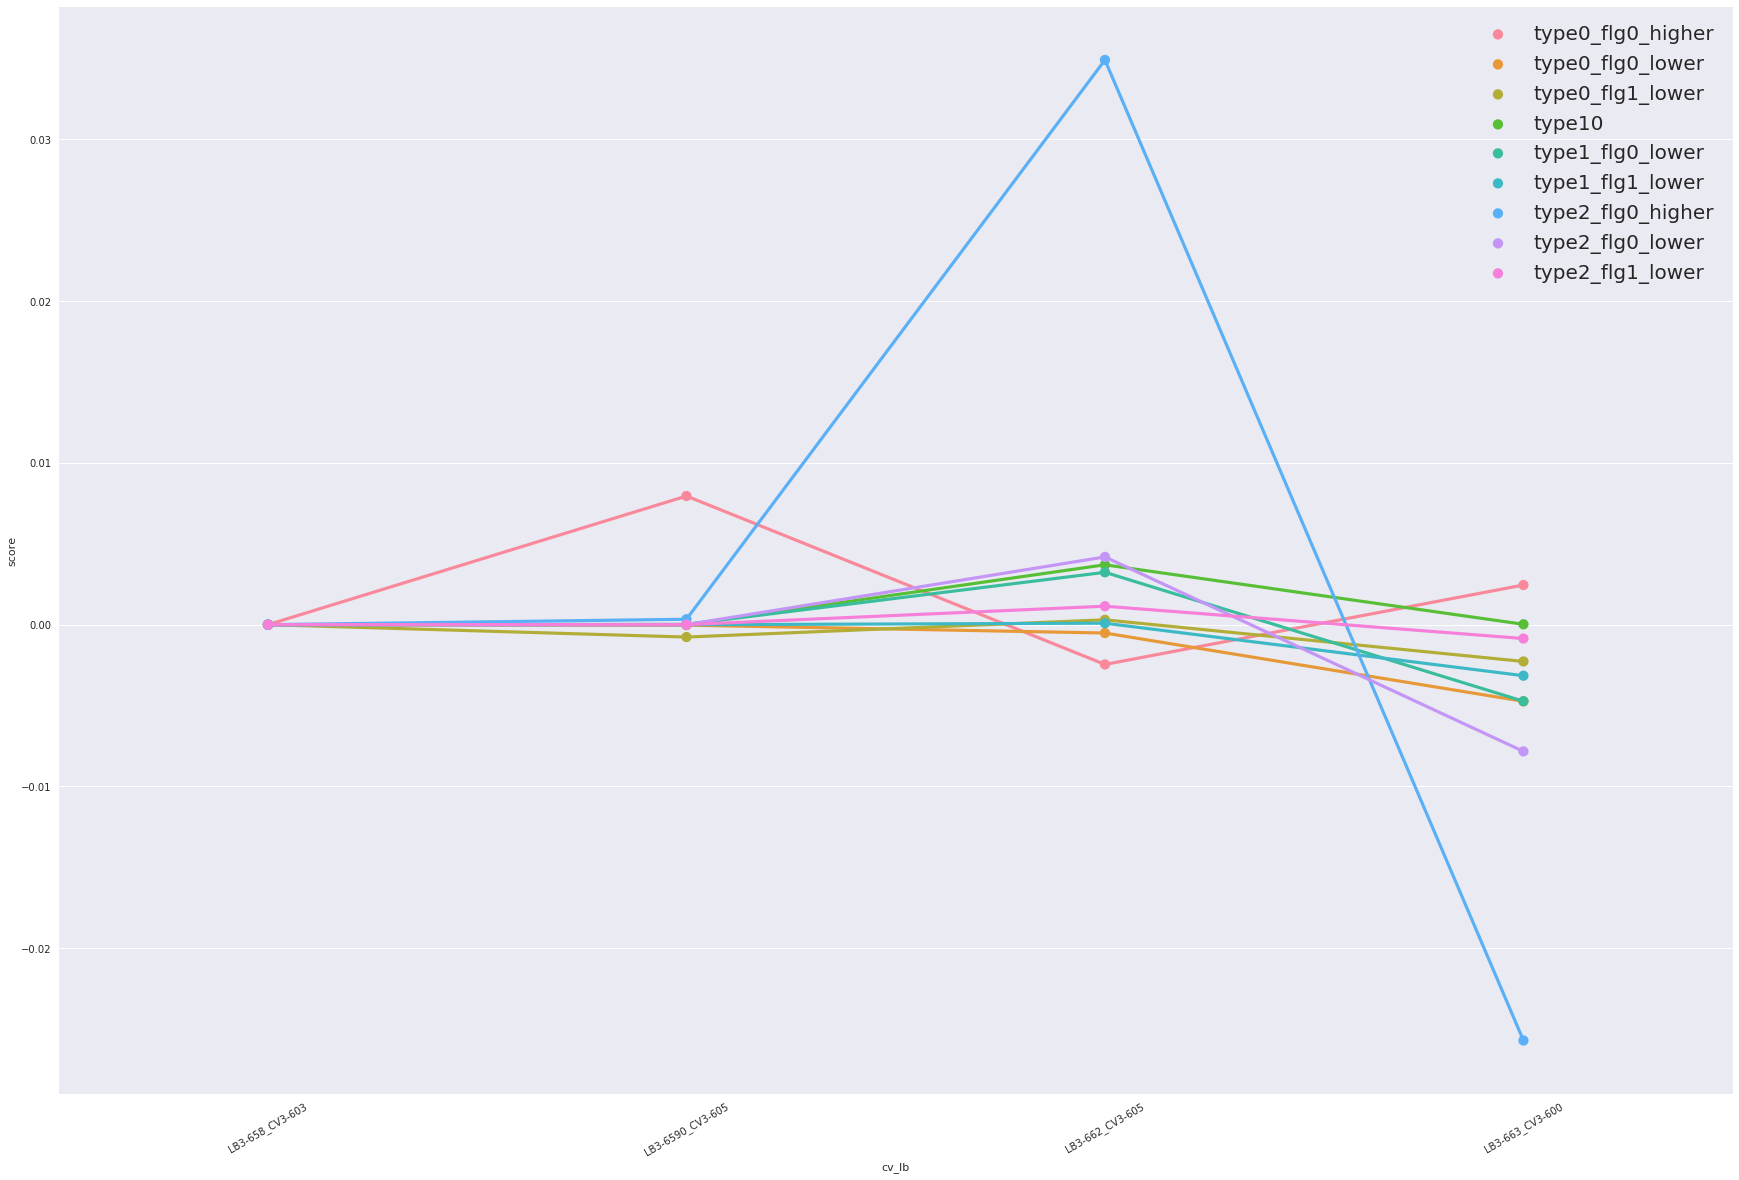

In [66]:
plt.figure(figsize=(30, 20))
sns.pointplot(data=df_viz, x='cv_lb', y='score', hue='group')
# sns.pointplot(data=df_viz[df_viz['group']=='type10'], x='cv_lb', y='score', hue='group')
plt.xticks(rotation='30')
plt.legend(fontsize=20)
plt.show()

Group: type0_flg0_higher | Count ID: 28285 | Count Outlier: 1717


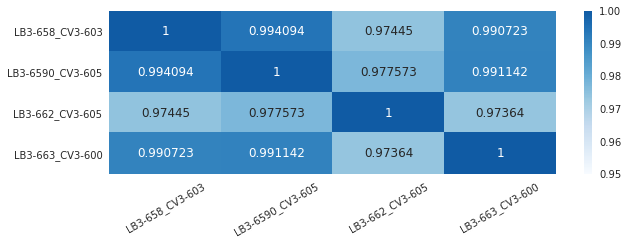

Group: type0_flg0_lower | Count ID: 19040 | Count Outlier: 90


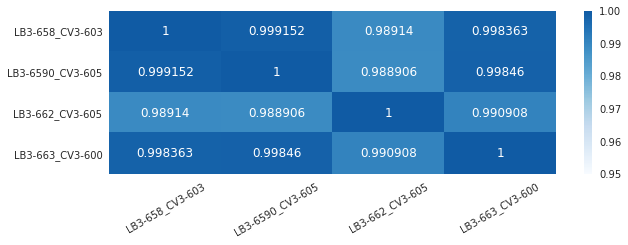

Group: type0_flg1_lower | Count ID: 1546 | Count Outlier: 4


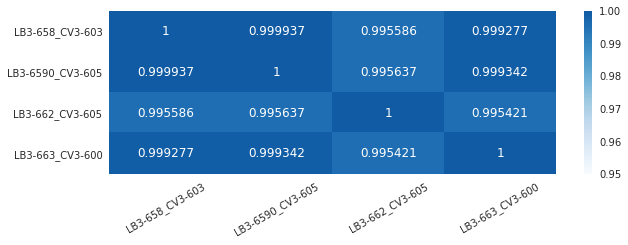

Group: type10 | Count ID: 27766 | Count Outlier: 0


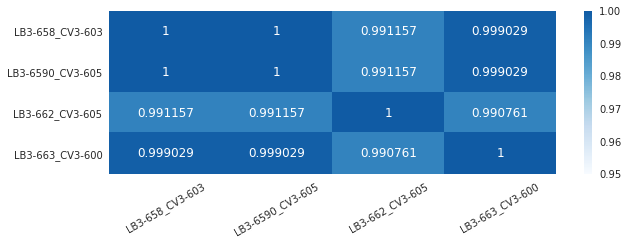

Group: type1_flg0_lower | Count ID: 10161 | Count Outlier: 14


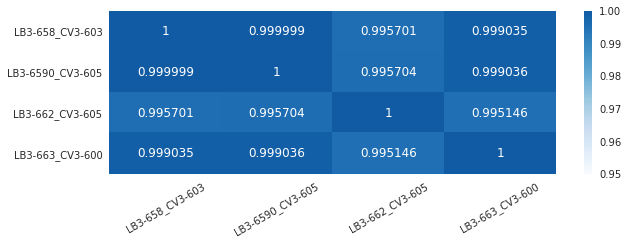

Group: type1_flg1_lower | Count ID: 7430 | Count Outlier: 11


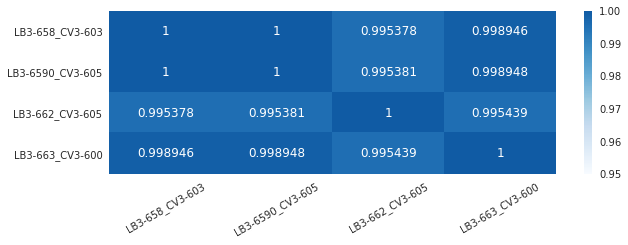

Group: type2_flg0_higher | Count ID: 5540 | Count Outlier: 96


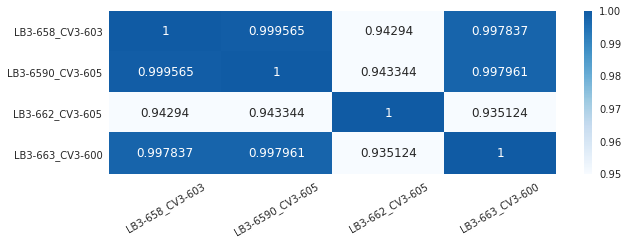

Group: type2_flg0_lower | Count ID: 97628 | Count Outlier: 273


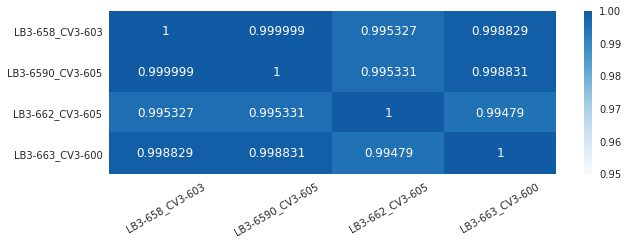

Group: type2_flg1_lower | Count ID: 4431 | Count Outlier: 0


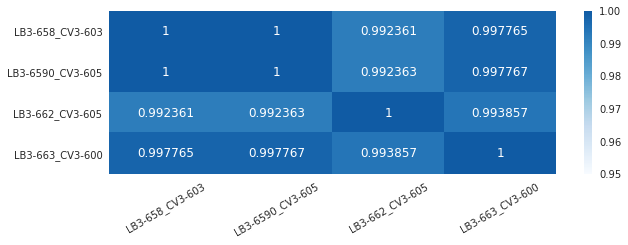

In [90]:
#========================================================================
# Corr Check
train = base[~base[target].isnull()]
train['outlier'] = train[target].map(lambda x: 1 if x<-30 else 0)
for group in group_list:
    tmp_group = train[train['group']==group]
    cnt_id = np.array(tmp_group.index).shape[0]
    if cnt_id<1000:
        continue
    cnt_out = tmp_group['outlier'].sum()
    print(f"Group: {group} | Count ID: {cnt_id} | Count Outlier: {cnt_out}")
    
    lb_list = sorted([col for col in tmp_group.columns if col.count('LB')])
    
    df_corr = tmp_group[lb_list]
    df_corr = df_corr.corr(method='pearson')
    plt.figure(figsize=(10, 3))
    sns.heatmap(df_corr, center = 0.98, vmin=0.95, annot=True, fmt='g', cmap='Blues')
    plt.xticks(rotation='30')
    plt.yticks(rotation='0')
    plt.show()

#========================================================================

In [34]:
#========================================================================
# alijsのOOFを結合して自分仕様にする
#========================================================================
from itertools import combinations
oof_list = glob.glob('../log_submit/alijs_submit/*.csv')
oof_combi = combinations(oof_list, 2)
tmp_list = []
for p1, p2 in oof_combi:
    if p1==p2:continue
    if p1[-8:]!=p2[-8:]:continue
    
    tmp1 = pd.read_csv(p1)
    tmp2 = pd.read_csv(p2)
    if len(tmp1.columns)==3:
        tmp1.drop(target, axis=1, inplace=True)
    if len(tmp2.columns)==3:
        tmp2.drop(target, axis=1, inplace=True)
        
    cv = re.search(r'CV([^/.]*)_LB', p1.replace('.', '-')).group(1)
    lb = re.search(r'LB([^/.]*).csv', p1.replace('.', '-')).group(1)
    pred_col = 'prediction'
        
    tmp1.columns = [key, pred_col]
    tmp2.columns = [key, pred_col]
    df = pd.concat([tmp1, tmp2], axis=0)
    print(p1, p2)
    save_path = f'../ensemble/good_submit_ensemble/0223_alijs_stack_submit_CV{cv}_LB{lb}'
    utils.to_pkl_gzip(obj=df, path=save_path)

../log_submit/alijs_submit/cv_pp_02221626_CV3.6063_LB3.6599.csv ../log_submit/alijs_submit/pp_02221626_CV3.6063_LB3.6599.csv
../log_submit/alijs_submit/pp_02222250_CV3.6035_LB.csv ../log_submit/alijs_submit/cv_pp_02222250_CV3.6035_LB.csv
